# ROMY Events - Plots Ratio

In [1]:
import os
import gc
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Configurations

In [3]:
config = {}

# path to data
config['path_to_data'] = data_path+"romy_events/data/"

config['path_to_figs'] = data_path+"romy_events/figures/"

config['path_to_mseed'] = data_path+"romy_events/data/waveforms/ACC/"

# specify event file
config['eventfile'] = "ROMYevents_2020_2023_status.csv"

# specify catalog
config['catalogfile'] = "catalogs/ROMY_global_catalog_20200101_20231231.pkl"

# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941


### Load Catalog

In [5]:
cat = pd.read_pickle(config['path_to_data']+config['catalogfile'])

# add row with UTC times
cat['time_utc'] = [str(obs.UTCDateTime(str(_e).split('.')[0], precision=0)) for _e in cat.timestamp]

cat['depth_km'] = cat.depth / 1000

In [6]:
cat

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km,time_utc,depth_km
0,2020-01-06 10:32:19.160,17.7486,-66.8286,8079.8,5.95,mb,0.000000e+00,273.611213,7683.547502,2020-01-06T10:32:19Z,8.0798
1,2020-01-07 06:05:19.680,2.3273,96.4130,20388.2,6.02,mb,7.038052e+04,91.926528,9456.374129,2020-01-07T06:05:19Z,20.3882
2,2020-01-07 08:24:25.120,17.8096,-66.7908,7922.0,6.27,mb,7.872596e+04,273.629169,7675.920763,2020-01-07T08:24:25Z,7.9220
3,2020-01-09 08:38:08.890,62.2654,171.0078,8959.8,5.97,mb,2.523497e+05,9.987013,7629.287864,2020-01-09T08:38:08Z,8.9598
4,2020-01-19 13:27:57.850,39.7669,77.1324,10361.2,5.78,mb,1.133739e+06,74.622163,5202.291787,2020-01-19T13:27:57Z,10.3612
...,...,...,...,...,...,...,...,...,...,...,...
1100,2023-12-20 12:11:22.030,-16.0280,-72.5450,94900.0,6.00,M,1.247675e+08,254.883009,10872.229523,2023-12-20T12:11:22Z,94.9000
1101,2023-12-23 17:48:05.220,52.0190,159.0030,36100.0,5.98,M,1.250469e+08,19.778726,8487.701245,2023-12-23T17:48:05Z,36.1000
1102,2023-12-28 09:15:18.470,44.5560,148.9440,45900.0,6.50,M,1.254482e+08,29.127618,8935.182118,2023-12-28T09:15:18Z,45.9000
1103,2023-12-28 09:37:27.210,44.4540,149.1610,38000.0,6.36,M,1.254495e+08,29.034678,8953.123325,2023-12-28T09:37:27Z,38.0000


### Load Event Data

In [7]:
# load data base
events = pd.read_csv(config['path_to_data']+config['eventfile'], header=0, skiprows=4)

# prepare dataframe
events.dropna(subset="Event", inplace=True)
events.sort_values(by="# Event")
events.reset_index(drop=True, inplace=True)

# add row with UTC times
events['time_utc'] = [str(obs.UTCDateTime(f"{_e.split('_')[1]}T{_e.split('_')[2]}", precision=0)) for _e in events.Event]

events

,# Event,Event,FUR,RLAS,ROMY-Z,ROMY-U,ROMY-V,ROMY-W,FURQ,RLASQ,ZQ,UQ,VQ,WQ,Comment,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,time_utc
0,0.0,000_20200107_060519_filtered.png,True,True,False,False,False,False,False,False,False,False,False,False,NaN,0.0,20200107.0,60519.0,filtered.png,2020-01-07T06:05:19Z
1,1.0,001_20200107_082425_filtered.png,True,True,False,False,False,False,False,False,False,False,False,False,NaN,1.0,20200107.0,82425.0,filtered.png,2020-01-07T08:24:25Z
2,2.0,002_20200119_165820_filtered.png,True,True,False,False,False,False,False,False,False,False,False,False,NaN,2.0,20200119.0,165820.0,filtered.png,2020-01-19T16:58:20Z
3,3.0,003_20200120_065138_filtered.png,True,False,False,False,False,False,False,False,False,False,False,False,NaN,3.0,20200120.0,65138.0,filtered.png,2020-01-20T06:51:38Z
4,4.0,004_20200124_175515_filtered.png,True,True,True,True,False,False,False,False,False,True,False,False,Z coda incomplete,4.0,20200124.0,175515.0,filtered.png,2020-01-24T17:55:15Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,423.0,423_20231211_063331_filtered.png,False,False,False,False,False,False,False,False,False,False,False,False,NaN,423.0,20231211.0,63331.0,filtered.png,2023-12-11T06:33:31Z
424,424.0,424_20231211_063331_filtered.png,False,False,False,False,False,False,False,False,False,False,False,False,NaN,424.0,20231211.0,63331.0,filtered.png,2023-12-11T06:33:31Z
425,425.0,425_20231228_091518_filtered.png,True,True,True,True,True,False,False,False,True,True,True,False,"Z interrupted at start, U interrupted, V inte...",425.0,20231228.0,91518.0,filtered.png,2023-12-28T09:15:18Z
426,426.0,426_20231228_093727_filtered.png,True,True,True,True,True,False,False,False,True,True,True,False,"Z interrupted at start, U interrupted, V inte...",426.0,20231228.0,93727.0,filtered.png,2023-12-28T09:37:27Z


### Merge Dataframes

In [8]:
df = pd.merge(left=cat, right=events, on="time_utc")

In [9]:
df

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km,time_utc,...,RLASQ,ZQ,UQ,VQ,WQ,Comment,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2020-01-07 06:05:19.680,2.3273,96.4130,20388.2,6.02,mb,7.038052e+04,91.926528,9456.374129,2020-01-07T06:05:19Z,...,False,False,False,False,False,NaN,0.0,20200107.0,60519.0,filtered.png
1,2020-01-07 08:24:25.120,17.8096,-66.7908,7922.0,6.27,mb,7.872596e+04,273.629169,7675.920763,2020-01-07T08:24:25Z,...,False,False,False,False,False,NaN,1.0,20200107.0,82425.0,filtered.png
2,2020-01-19 16:58:20.270,-0.0922,123.7908,134364.4,6.04,mb,1.146361e+06,72.743117,11667.078041,2020-01-19T16:58:20Z,...,False,False,False,False,False,NaN,2.0,20200119.0,165820.0,filtered.png
3,2020-01-20 06:51:38.360,-59.3480,-26.3762,103227.9,6.28,mb,1.196359e+06,199.669607,12400.384022,2020-01-20T06:51:38Z,...,False,False,False,False,False,NaN,3.0,20200120.0,65138.0,filtered.png
4,2020-01-24 17:55:15.540,38.2987,39.1475,12303.2,6.15,mb,1.581776e+06,105.672138,2496.661360,2020-01-24T17:55:15Z,...,False,False,True,False,False,Z coda incomplete,4.0,20200124.0,175515.0,filtered.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,2023-12-11 06:33:31.900,-18.9340,-175.5060,245000.0,6.20,M,1.239697e+08,12.888509,16704.989259,2023-12-11T06:33:31Z,...,False,False,False,False,False,NaN,423.0,20231211.0,63331.0,filtered.png
436,2023-12-11 06:33:31.900,-18.9340,-175.5060,245000.0,6.20,M,1.239697e+08,12.888509,16704.989259,2023-12-11T06:33:31Z,...,False,False,False,False,False,NaN,424.0,20231211.0,63331.0,filtered.png
437,2023-12-28 09:15:18.470,44.5560,148.9440,45900.0,6.50,M,1.254482e+08,29.127618,8935.182118,2023-12-28T09:15:18Z,...,False,True,True,True,False,"Z interrupted at start, U interrupted, V inte...",425.0,20231228.0,91518.0,filtered.png
438,2023-12-28 09:37:27.210,44.4540,149.1610,38000.0,6.36,M,1.254495e+08,29.034678,8953.123325,2023-12-28T09:37:27Z,...,False,True,True,True,False,"Z interrupted at start, U interrupted, V inte...",426.0,20231228.0,93727.0,filtered.png


### Select events with RLAS and ROMY-Z

In [10]:
select_z_idx = list(np.where((df.RLAS == True) & (df['ROMY-Z'] == True) & (df.ZQ == False))[0])

select_z = df[df.index.isin(select_z_idx)]

In [11]:
select_z

,timestamp,latitude,longitude,depth,magnitude,type,seconds,backazimuth,distances_km,time_utc,...,RLASQ,ZQ,UQ,VQ,WQ,Comment,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
4,2020-01-24 17:55:15.540,38.2987,39.1475,12303.2,6.15,mb,1.581776e+06,105.672138,2496.661360,2020-01-24T17:55:15Z,...,False,False,True,False,False,Z coda incomplete,4.0,20200124.0,175515.0,filtered.png
14,2020-05-02 12:51:05.870,34.1862,25.7680,13468.2,6.43,mb,1.011713e+07,136.885653,1964.844686,2020-05-02T12:51:05Z,...,False,False,False,False,False,NaN,14.0,20200502.0,125105.0,filtered.png
28,2020-07-22 20:07:18.730,33.0824,86.8385,10000.0,6.20,mb,1.714170e+07,75.534793,6341.853307,2020-07-22T20:07:18Z,...,False,False,False,False,False,NaN,28.0,20200722.0,200718.0,filtered.png
36,2020-09-01 04:09:28.400,-27.9890,-71.1737,16693.5,6.40,mb,2.062663e+07,245.646435,11748.735840,2020-09-01T04:09:28Z,...,False,False,False,False,False,NaN,36.0,20200901.0,40928.0,filtered.png
38,2020-09-06 06:51:18.630,7.6300,-37.2557,11851.5,6.18,mb,2.106834e+07,241.810156,6394.083290,2020-09-06T06:51:18Z,...,False,False,False,False,False,NaN,38.0,20200906.0,65118.0,filtered.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,2023-10-31 12:33:45.010,-28.7230,-71.3850,38700.0,6.70,M,1.204489e+08,245.260571,11821.894915,2023-10-31T12:33:45Z,...,False,False,False,False,False,NaN,405.0,20231031.0,123345.0,filtered.png
421,2023-12-02 15:00:09.380,8.6830,126.8850,38400.0,6.63,M,1.232225e+08,64.694732,11123.408162,2023-12-02T15:00:09Z,...,False,False,False,False,False,NaN,411.0,20231202.0,150009.0,filtered.png
422,2023-12-02 15:06:47.330,8.4440,126.9490,40000.0,7.40,M,1.232229e+08,64.791279,11148.636359,2023-12-02T15:06:47Z,...,False,False,False,False,False,NaN,412.0,20231202.0,150647.0,filtered.png
423,2023-12-02 15:31:28.240,8.5890,126.8690,40000.0,6.89,M,1.232243e+08,64.765433,11130.560323,2023-12-02T15:31:28Z,...,False,False,False,False,False,NaN,413.0,20231202.0,153128.0,filtered.png


In [12]:
# load data

amp_type = "maxima" # maxima  perc95  mean

amp = pd.read_pickle(config['path_to_data']+f"amplitudes_{amp_type}.pkl")


In [13]:
romy_z = {}
rlas_z = {}
fur_z = {}
wet_z = {}

# extract frequency bands
fbands = list(amp['014'].keys())

# fill dictionary with array for romy and rlas for all events with fband keys
for fband in fbands:
    romy_z[str(fband)] = []
    rlas_z[str(fband)] = []
    fur_z[str(fband)] = []
    wet_z[str(fband)] = []

    try:
        for evn in amp.keys():
            romy_z[str(fband)].append(amp[evn][fband]['ROMY.BJZ'])
            rlas_z[str(fband)].append(amp[evn][fband]['RLAS.BJZ'])
            fur_z[str(fband)].append(amp[evn][fband]['FUR.BHZ'])
            wet_z[str(fband)].append(amp[evn][fband]['WET.BHZ'])
    except:
        continue

# create lists of all maxima for plotting
romy_z_arr = []
rlas_z_arr = []
fur_z_arr = []
wet_z_arr = []

for fband in fbands:
    romy_z_arr.append(romy_z[str(fband)])
    rlas_z_arr.append(rlas_z[str(fband)])
    fur_z_arr.append(fur_z[str(fband)])
    wet_z_arr.append(wet_z[str(fband)])


In [14]:
print("Event Count: ", np.shape(fur_z_arr)[1])

Event Count:  85


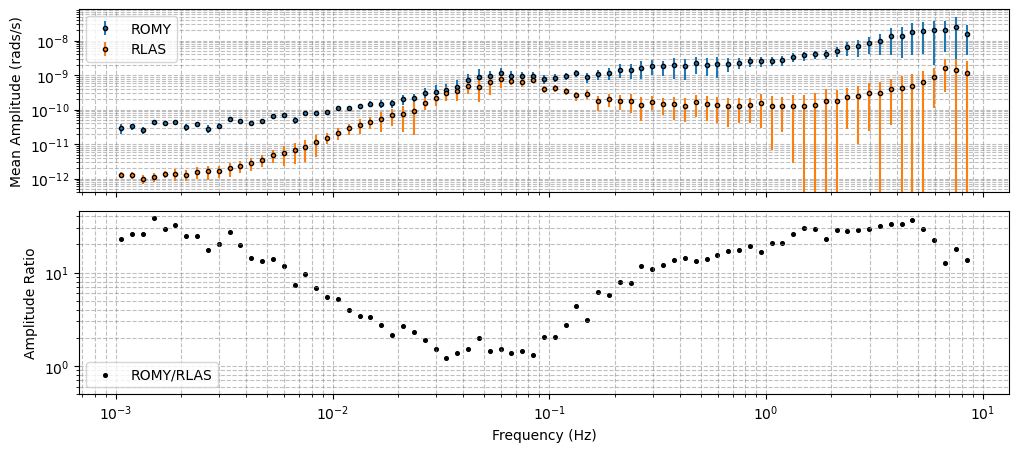

In [15]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)



    m_rlas, m_romy = [], []

    e_upper, e_lower = [], []
    for _i, (fb, r1) in enumerate(zip(fbands, romy_z_arr)):
        if _i == 0:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70), label="ROMY",
                           fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
                          )
        else:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70),
                           fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
                          )

        e_upper.append(np.nanmean(r1)+np.nanstd(r1))
        e_lower.append(np.nanmean(r1)-np.nanstd(r1))
        m_romy.append(np.nanmean(r1))

    e_upper, e_lower = [], []
    for _i, (fb, r1) in enumerate(zip(fbands, rlas_z_arr)):

        if _i == 0:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70), label="RLAS",
                           fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
                          )
        else:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70),
                           fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
                          )

        e_upper.append(np.nanmean(r1)+np.nanstd(r1))
        e_lower.append(np.nanmean(r1)-np.nanstd(r1))
        m_rlas.append(np.nanmean(r1))


    ax[1].scatter(fbands, np.array(m_romy)/np.array(m_rlas), s=7, color="k", label="ROMY/RLAS")

    for _k in range(Nrow):
        ax[_k].legend()
        ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[_k].set_xscale("log")
        ax[_k].set_yscale("log")

    ax[0].set_ylabel("Mean Amplitude (rads/s)")
    ax[1].set_ylabel("Amplitude Ratio")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[1].set_ylim(bottom=0.5)

    plt.show();
    return fig

fig = __makeplot();


fig.savefig(config['path_to_figs']+f"RomyEvents_Amplitude_Ratio_RomyRlas_{amp_type}.png", format="png", dpi=150, bbox_inches='tight')


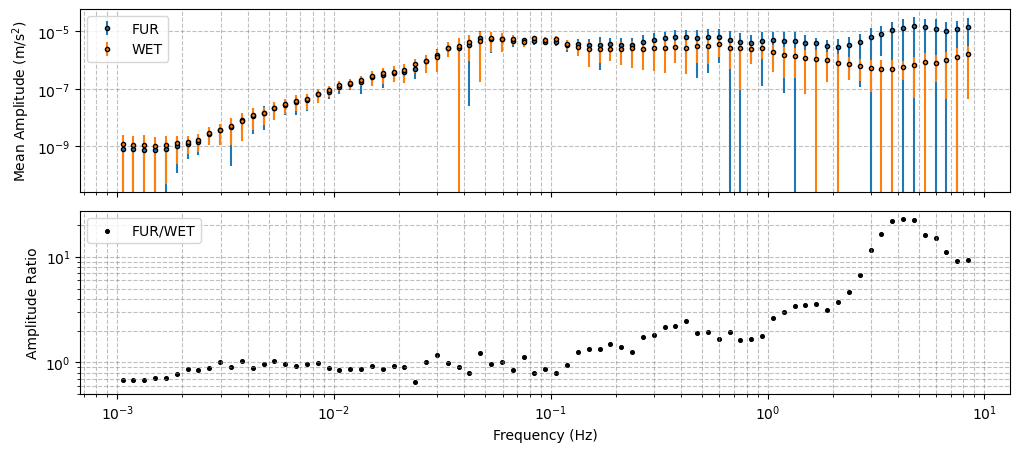

In [16]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 2, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)



    m_rlas, m_romy = [], []

    e_upper, e_lower = [], []
    for _i, (fb, r1) in enumerate(zip(fbands, fur_z_arr)):
        if _i == 0:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70), label="FUR",
                           fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
                          )
        else:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70),
                           fmt="o", markersize=3, color="tab:blue", markeredgecolor="k",
                          )

        e_upper.append(np.nanmean(r1)+np.nanstd(r1))
        e_lower.append(np.nanmean(r1)-np.nanstd(r1))
        m_romy.append(np.nanmean(r1))

    e_upper, e_lower = [], []
    for _i, (fb, r1) in enumerate(zip(fbands, wet_z_arr)):

        if _i == 0:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70), label="WET",
                           fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
                          )
        else:
            ax[0].errorbar(fb, np.nanmean(r1), yerr=np.nanpercentile(r1, 70),
                           fmt="o", markersize=3, color="tab:orange", markeredgecolor="k",
                          )

        e_upper.append(np.nanmean(r1)+np.nanstd(r1))
        e_lower.append(np.nanmean(r1)-np.nanstd(r1))
        m_rlas.append(np.nanmean(r1))


    ax[1].scatter(fbands, np.array(m_romy)/np.array(m_rlas), s=7, color="k", label="FUR/WET")

    for _k in range(Nrow):
        ax[_k].legend()
        ax[_k].grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)
        ax[_k].set_xscale("log")
        ax[_k].set_yscale("log")

    ax[0].set_ylabel("Mean Amplitude (m/s$^2$)")
    ax[1].set_ylabel("Amplitude Ratio")
    ax[1].set_xlabel("Frequency (Hz)")

    ax[1].set_ylim(bottom=0.5)

    plt.show();
    return fig

fig = __makeplot();


fig.savefig(config['path_to_figs']+f"RomyEvents_Amplitude_Ratio_FURWET_{amp_type}.png", format="png", dpi=150, bbox_inches='tight')


In [201]:
def __select_frequency(dic, f=0.1):

    # select first event
    ev = list(dic.keys())[0]

    # select all frequencies
    freqs = np.array(list(dic[ev].keys()))

    # determine closest to request
    idx = np.absolute(freqs - f).argmin()
    val = freqs[idx]

    amp1 = {}
    amp2 = {}
    for k in dic.keys():
        amp1[k] = dic[k][val]["ROMY.BJZ"]
        amp2[k] = dic[k][val]["RLAS.BJZ"]

    return amp1, amp2, val

amp1_romyz, amp1_rlasz, fval = __select_frequency(amp, f=10)

/tmp/ipykernel_540723/1869620333.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]
/tmp/ipykernel_540723/1869620333.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]
/tmp/ipykernel_540723/1869620333.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

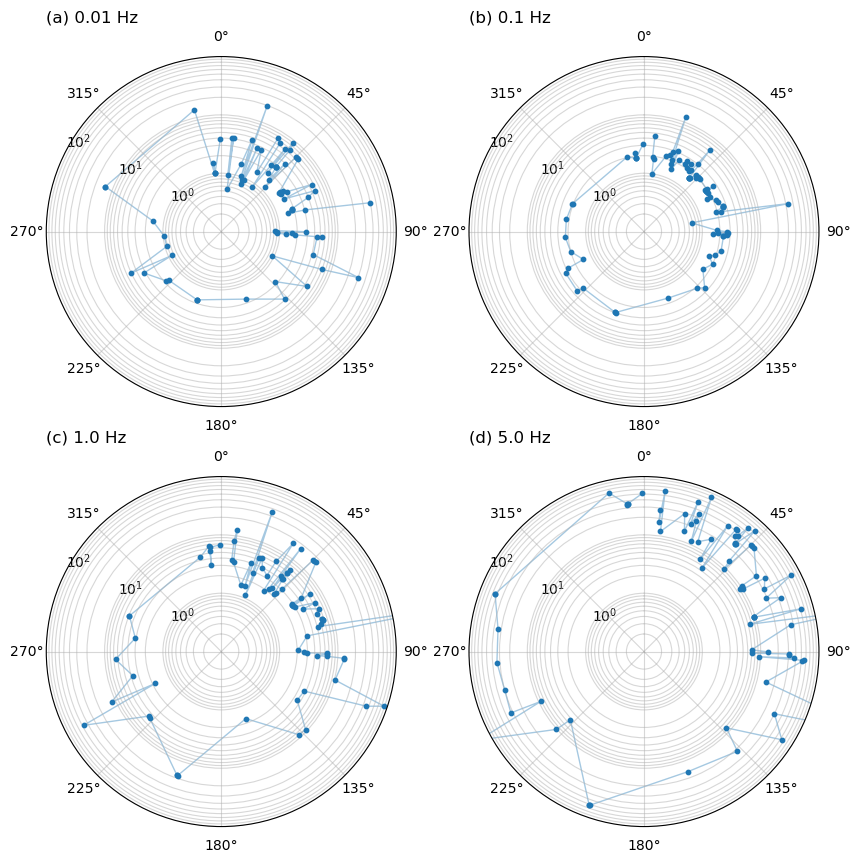

In [257]:
freqs = [0.01, 0.1, 1.0, 5.0]
rows = [0, 0, 1, 1]
cols = [0, 1, 0, 1]
lbl = ["(a)", "(b)", "(c)", "(d)"]

Nrow, Ncol = 2, 2

fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 10), subplot_kw={'projection': 'polar'})


for _n, (i, j, _f, _l) in enumerate(zip(rows, cols, freqs, lbl)):

    amp1_romyz, amp1_rlasz, fval = __select_frequency(amp, f=_f)

    # create new frame
    amp1_df = pd.DataFrame()
    amp1_df['ev_num'] = [str(_k) for _k in amp1_romyz.keys()]
    amp1_df['romyz'] = [_v for _v in amp1_romyz.values()]
    amp1_df['rlasz'] = [_v for _v in amp1_rlasz.values()]

    # select subset of event frame
    tmp = select_z[['# Event', 'backazimuth']]
    tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]

    # merge frames based on event number
    amp1 = pd.merge(left=tmp, right=amp1_df, on="ev_num")

    amp1 = amp1.sort_values(by="backazimuth", ascending=True)

    ax[i, j].scatter(np.deg2rad(amp1.backazimuth), amp1.romyz/amp1.rlasz, s=10, zorder=2)
    ax[i, j].plot(np.deg2rad(amp1.backazimuth), amp1.romyz/amp1.rlasz, zorder=1, alpha=0.4, lw=1)

    ax[i, j].grid(True, which="both", axis="both", zorder=0, alpha=0.5)
    ax[i, j].set_rscale("log")
    ax[i, j].set_rlabel_position(-62.5)
    ax[i, j].set_theta_zero_location("N")
    ax[i, j].set_theta_direction(-1)
    ax[i, j].set_rmin(1e-1)
    ax[i, j].set_rmax(1e2)

    ax[i, j].set_title(f"{_l} {_f} Hz", loc="left")

plt.show();

In [231]:
# create new frame
amp1_df = pd.DataFrame()
amp1_df['ev_num'] = [str(_k) for _k in amp1_romyz.keys()]
amp1_df['romyz'] = [_v for _v in amp1_romyz.values()]
amp1_df['rlasz'] = [_v for _v in amp1_rlasz.values()]

# select subset of event frame
tmp = select_z[['# Event', 'backazimuth']]
tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]


amp1 = pd.merge(left=tmp, right=amp1_df, on="ev_num")


/tmp/ipykernel_540723/4100713166.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['ev_num'] = [str(int(_ev)).rjust(3, "0") for _ev in tmp['# Event']]


In [237]:
amp1.backazimuth

0     136.885653
1      75.534793
2     241.810156
3     227.189184
4      38.368446
         ...    
82     56.095085
83     56.732905
84     57.777946
85     90.125822
86    245.260571
Name: backazimuth, Length: 87, dtype: float64

In [238]:
np.deg2rad(amp1.backazimuth)

0     2.389105
1     1.318331
2     4.220383
3     3.965199
4     0.669656
        ...   
82    0.979044
83    0.990176
84    1.008415
85    1.572992
86    4.280604
Name: backazimuth, Length: 87, dtype: float64

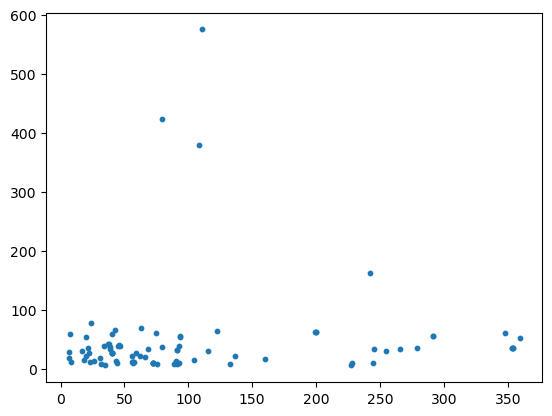

In [244]:
# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
fig, ax = plt.subplots()

ax.scatter(amp1.backazimuth, amp1.romyz/amp1.rlasz, s=10, zorder=2)
# ax.scatter(np.deg2rad(amp1.backazimuth), amp1.romyz/amp1.rlasz, s=10, zorder=2)

# ax.set_rscale("log")
# ax.set_rlabel_position(-62.5)
# ax.grid(True, which="both", axis="both")
# ax.set_theta_zero_location("N")
